In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time

print("TensorFlow version:", tf.__version__)

# Configuration
img_height, img_width = 200, 200
batch_size = 32
epochs = 15
data_dir = 'asl_alphabet_train'  # This folder should contain subfolders for each class

# Create data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest',
    validation_split=0.2
)

# Create training and validation data generators
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

print("Number of classes:", len(train_data.class_indices))
print("Class indices:", train_data.class_indices)
num_classes = len(train_data.class_indices)


2025-05-05 21:49:15.496909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746499755.508040   86033 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746499755.511708   86033 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746499755.521823   86033 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746499755.521845   86033 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746499755.521847   86033 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Number of classes: 29
Class indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [2]:
# Define the CNN model
def base_model():
    model = tf.keras.Sequential([
        # Inputs in [0..1], assuming your pipeline divides by 255 already
        tf.keras.layers.InputLayer(input_shape=(200,200,3)),
        # ─── Block 1 ────────────────────────────────────────────────
        tf.keras.layers.Conv2D(64,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.SpatialDropout2D(0.25),
        # ─── Block 2 ────────────────────────────────────────────────
        tf.keras.layers.Conv2D(128,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.SpatialDropout2D(0.25),
        # ─── Block 3 ────────────────────────────────────────────────
        tf.keras.layers.Conv2D(256,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.SpatialDropout2D(0.25),
        # ─── Block 4 ────────────────────────────────────────────────
        tf.keras.layers.Conv2D(512,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512,3,padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.SpatialDropout2D(0.25),
        # ─── Dense head ───────────────────────────────────────────
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        # ─── Linear logits for classes ─────────────────────────
        tf.keras.layers.Dense(num_classes, activation=None, name="logits")
    ])
    return model

# Create the model
model = base_model()

# Add softmax activation for final output
model_with_softmax = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

# Compile the model
model_with_softmax.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print model summary
model_with_softmax.summary()

# Define callbacks
checkpoint_path = "asl_model_checkpoint.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        monitor='val_accuracy', 
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
history = model_with_softmax.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks
)

/home/donald/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1746499777.160297   86033 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5206 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 29)             │    42,459,229 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 29)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,459,229 (161.97 MB)

 Trainable params: 42,454,365 (161.95 MB)

 Non-trainable params: 4,864 (19.00 KB)

/home/donald/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1746499781.598242   86197 service.cc:152] XLA service 0x7f44e00017c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746499781.598266   86197 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-05-05 21:49:41.702069: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746499782.206210   86197 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746499801.593845   86197 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2083 - loss: 3.0893
Epoch 1: val_accuracy improved from -inf to 0.43207, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 418s 182ms/step - accuracy: 0.2084 - loss: 3.0889 - val_accuracy: 0.4321 - val_loss: 2.2819 - learning_rate: 0.0010
Epoch 2/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7981 - loss: 0.6009
Epoch 2: val_accuracy improved from 0.43207 to 0.78402, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 364s 167ms/step - accuracy: 0.7981 - loss: 0.6009 - val_accuracy: 0.7840 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 3/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9000 - loss: 0.3056
Epoch 3: val_accuracy improved from 0.78402 to 0.82868, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 363s 167ms/step - accuracy: 0.9000 - loss: 0.3056 - val_accuracy: 0.8287 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 4/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9283 - loss: 0.2182
Epoch 4: val_accuracy improved from 0.82868 to 0.86914, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 369s 169ms/step - accuracy: 0.9283 - loss: 0.2182 - val_accuracy: 0.8691 - val_loss: 0.4274 - learning_rate: 0.0010
Epoch 5/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9464 - loss: 0.1645
Epoch 5: val_accuracy did not improve from 0.86914
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 364s 167ms/step - accuracy: 0.9464 - loss: 0.1645 - val_accuracy: 0.8222 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 6/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9555 - loss: 0.1420
Epoch 6: val_accuracy did not improve from 0.86914
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 368s 169ms/step - accuracy: 0.9555 - loss: 0.1420 - val_accuracy: 0.8497 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 7/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9608 - loss: 0.1194
Epoch 7: val_accuracy improved from 0.86914 to 0.88695, saving model to asl_model_checkpoint.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 367s 169ms/step - accuracy: 0.9608 - loss: 0.1194 - val_accuracy: 0.8870 - val_loss: 0.4656 - learning_rate: 0.0010
Epoch 8/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9746 - loss: 0.0830
Epoch 8: val_accuracy improved from 0.88695 to 0.90770, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 367s 168ms/step - accuracy: 0.9746 - loss: 0.0830 - val_accuracy: 0.9077 - val_loss: 0.3743 - learning_rate: 5.0000e-04
Epoch 9/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9813 - loss: 0.0578
Epoch 9: val_accuracy improved from 0.90770 to 0.91397, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 363s 167ms/step - accuracy: 0.9813 - loss: 0.0578 - val_accuracy: 0.9140 - val_loss: 0.3341 - learning_rate: 5.0000e-04
Epoch 10/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9828 - loss: 0.0553
Epoch 10: val_accuracy did not improve from 0.91397
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 365s 168ms/step - accuracy: 0.9828 - loss: 0.0553 - val_accuracy: 0.8830 - val_loss: 0.4406 - learning_rate: 5.0000e-04
Epoch 11/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9850 - loss: 0.0472
Epoch 11: val_accuracy improved from 0.91397 to 0.93006, saving model to asl_model_checkpoint.h5


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 364s 167ms/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9301 - val_loss: 0.2742 - learning_rate: 5.0000e-04
Epoch 12/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9852 - loss: 0.0489
Epoch 12: val_accuracy did not improve from 0.93006
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 363s 167ms/step - accuracy: 0.9852 - loss: 0.0489 - val_accuracy: 0.9270 - val_loss: 0.2697 - learning_rate: 5.0000e-04
Epoch 13/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9864 - loss: 0.0427
Epoch 13: val_accuracy did not improve from 0.93006
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 363s 167ms/step - accuracy: 0.9864 - loss: 0.0427 - val_accuracy: 0.9147 - val_loss: 0.3574 - learning_rate: 5.0000e-04
Epoch 14/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9869 - loss: 0.0412
Epoch 14: val_accuracy did not improve from 0.93006
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 365s 168ms/step - accuracy: 0.9869 - loss: 0.0412 - val_accuracy: 0.9092 - val_loss: 0.

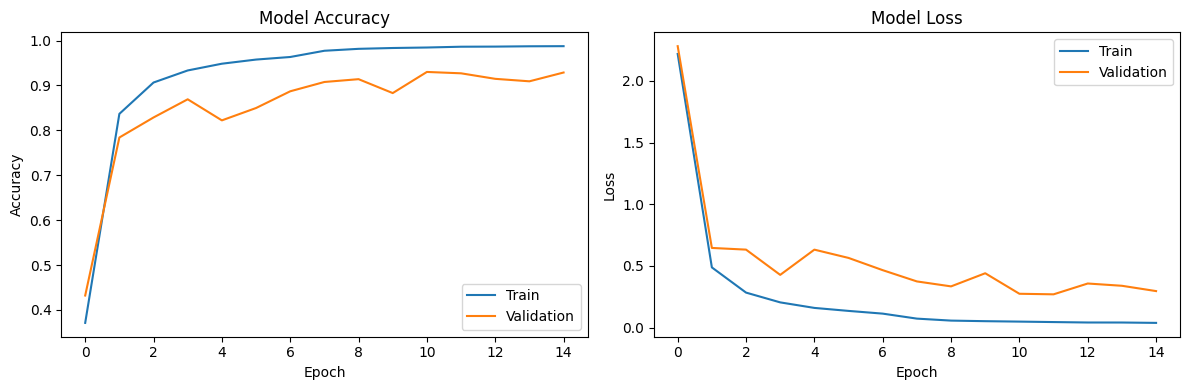

544/544 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.9264 - loss: 0.2793


Validation accuracy: 0.9270
Validation loss: 0.2768
Final model saved to asl_model_final.h5

--- Starting model quantization ---
INFO:tensorflow:Assets written to: /tmp/tmp5o798peq/assets


INFO:tensorflow:Assets written to: /tmp/tmp5o798peq/assets


Saved artifact at '/tmp/tmp5o798peq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  139938096502160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096507088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096498640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096507792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096510784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096693488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096508320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096697536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096696480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096698592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1399380966

/home/donald/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1746630764.882424   86033 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746630764.882447   86033 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-07 10:12:44.882557: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5o798peq
2025-05-07 10:12:44.884114: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-07 10:12:44.884120: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5o798peq
2025-05-07 10:12:44.899266: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-07 10:12:45.052887: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5o79

Original model size: 485.98 MB
Quantized model size: 40.56 MB
Size reduction: 91.65%
Quantization completed in 58.98 seconds
Quantized model saved to asl_model_quantized_int8.tflite

--- Starting float16 quantization ---
INFO:tensorflow:Assets written to: /tmp/tmpti47duz5/assets


INFO:tensorflow:Assets written to: /tmp/tmpti47duz5/assets


Saved artifact at '/tmp/tmpti47duz5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  139938096502160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096507088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096498640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096507792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096510784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096693488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096508320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096697536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096696480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938096698592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1399380966

W0000 00:00:1746630825.080644   86033 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746630825.080669   86033 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-07 10:13:45.080786: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpti47duz5
2025-05-07 10:13:45.082337: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-07 10:13:45.082342: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpti47duz5
2025-05-07 10:13:45.098031: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-07 10:13:45.237747: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpti47duz5
2025-05-07 10:13:45.260753: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 179969 microseconds.


Original model size: 485.98 MB
Float16 quantized model size: 80.99 MB
Size reduction: 83.33%
Float16 quantization completed in 5.32 seconds
Float16 quantized model saved to asl_model_quantized_float16.tflite

--- Evaluating models ---
Evaluating original model:
544/544 ━━━━━━━━━━━━━━━━━━━━ 71s 130ms/step - accuracy: 0.9294 - loss: 0.2805
Original model accuracy: 0.9284

--- Evaluating TFLite model: asl_model_quantized_int8.tflite ---


/home/donald/.local/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite Model Accuracy: 0.7906
Evaluated on 1600 samples

--- Evaluating TFLite model: asl_model_quantized_float16.tflite ---
TFLite Model Accuracy: 0.9394
Evaluated on 1600 samples

--- Model Comparison Summary ---
Original Model Accuracy: 0.9284
INT8 Quantized Model Accuracy: 0.7906
Float16 Quantized Model Accuracy: 0.9394
Original model size: 485.98 MB
INT8 Quantized model size: 40.56 MB
Float16 Quantized model size: 80.99 MB


In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

plt.savefig('asl_training_history.png')
plt.show()

# Evaluate the model on validation data
val_loss, val_acc = model_with_softmax.evaluate(val_data)
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

# Save the final model
model_with_softmax.save('asl_model_final.h5')
print("Final model saved to asl_model_final.h5")

# ----------------- MODEL QUANTIZATION -----------------

# Define representative dataset for quantization
def representative_dataset():
    for i in range(10):  # Use a limited number of batches for calibration
        batch = next(iter(val_data))[0]
        yield [batch]

# Function to apply post-training quantization
def quantize_model(model_path, output_path):
    print("\n--- Starting model quantization ---")
    
    # Convert to TF Lite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model_with_softmax)
    
    # Set optimization flags
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Apply full integer quantization
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    
    # Convert the model
    start_time = time.time()
    quantized_tflite_model = converter.convert()
    conversion_time = time.time() - start_time
    
    # Save the quantized model
    with open(output_path, 'wb') as f:
        f.write(quantized_tflite_model)
    
    # Calculate model size reduction
    original_size = os.path.getsize(model_path)
    quantized_size = os.path.getsize(output_path)
    size_reduction = (1 - quantized_size / original_size) * 100
    
    print(f"Original model size: {original_size / (1024 * 1024):.2f} MB")
    print(f"Quantized model size: {quantized_size / (1024 * 1024):.2f} MB")
    print(f"Size reduction: {size_reduction:.2f}%")
    print(f"Quantization completed in {conversion_time:.2f} seconds")
    print(f"Quantized model saved to {output_path}")
    
    return quantized_tflite_model

# Also create a float16 quantized model for better accuracy with smaller size
def quantize_model_float16(model_path, output_path):
    print("\n--- Starting float16 quantization ---")
    
    # Convert to TF Lite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model_with_softmax)
    
    # Set optimization flags for float16 quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    
    # Convert the model
    start_time = time.time()
    quantized_tflite_model = converter.convert()
    conversion_time = time.time() - start_time
    
    # Save the quantized model
    with open(output_path, 'wb') as f:
        f.write(quantized_tflite_model)
    
    # Calculate model size reduction
    original_size = os.path.getsize(model_path)
    quantized_size = os.path.getsize(output_path)
    size_reduction = (1 - quantized_size / original_size) * 100
    
    print(f"Original model size: {original_size / (1024 * 1024):.2f} MB")
    print(f"Float16 quantized model size: {quantized_size / (1024 * 1024):.2f} MB")
    print(f"Size reduction: {size_reduction:.2f}%")
    print(f"Float16 quantization completed in {conversion_time:.2f} seconds")
    print(f"Float16 quantized model saved to {output_path}")
    
    return quantized_tflite_model

# Evaluate TFLite model performance
def evaluate_tflite_model(tflite_model_path):
    print(f"\n--- Evaluating TFLite model: {tflite_model_path} ---")
    
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Check if the model is quantized to uint8
    is_quantized = input_details[0]['dtype'] == np.uint8
    
    # Get input quantization parameters if model is quantized
    if is_quantized:
        input_scale, input_zero_point = input_details[0]['quantization']
    
    # Prepare for evaluation
    correct_predictions = 0
    total_samples = 0
    
    # Use a limited number of batches for evaluation
    num_eval_batches = 50
    
    for i in range(num_eval_batches):
        try:
            images, labels = next(iter(val_data))
            batch_size = images.shape[0]
            total_samples += batch_size
            
            for j in range(batch_size):
                image = images[j:j+1]
                label = int(labels[j])
                
                # Preprocess the image based on model requirements
                if is_quantized:
                    # Quantize the input
                    image = np.uint8(image / input_scale + input_zero_point)
                
                # Set the tensor to point to the input data to be processed
                interpreter.set_tensor(input_details[0]['index'], image)
                
                # Run inference
                interpreter.invoke()
                
                # Get prediction results
                output_data = interpreter.get_tensor(output_details[0]['index'])
                
                # Get prediction result
                if is_quantized:
                    # Dequantize the output
                    output_scale, output_zero_point = output_details[0]['quantization']
                    output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
                
                predicted_class = np.argmax(output_data)
                
                if predicted_class == label:
                    correct_predictions += 1
        
        except StopIteration:
            break
    
    # Calculate accuracy
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    print(f"TFLite Model Accuracy: {accuracy:.4f}")
    print(f"Evaluated on {total_samples} samples")
    
    return accuracy

# Execute quantization after training
if os.path.exists('asl_model_final.h5'):
    # Quantize to int8
    quantized_model = quantize_model('asl_model_final.h5', 'asl_model_quantized_int8.tflite')
    
    # Quantize to float16
    quantized_model_float16 = quantize_model_float16('asl_model_final.h5', 'asl_model_quantized_float16.tflite')
    
    # Evaluate the quantized models
    print("\n--- Evaluating models ---")
    print("Evaluating original model:")
    val_loss, val_acc = model_with_softmax.evaluate(val_data)
    print(f"Original model accuracy: {val_acc:.4f}")
    
    # Evaluate int8 quantized model
    int8_accuracy = evaluate_tflite_model('asl_model_quantized_int8.tflite')
    
    # Evaluate float16 quantized model
    float16_accuracy = evaluate_tflite_model('asl_model_quantized_float16.tflite')
    
    # Print comparison summary
    print("\n--- Model Comparison Summary ---")
    print(f"Original Model Accuracy: {val_acc:.4f}")
    print(f"INT8 Quantized Model Accuracy: {int8_accuracy:.4f}")
    print(f"Float16 Quantized Model Accuracy: {float16_accuracy:.4f}")
    print(f"Original model size: {os.path.getsize('asl_model_final.h5') / (1024 * 1024):.2f} MB")
    print(f"INT8 Quantized model size: {os.path.getsize('asl_model_quantized_int8.tflite') / (1024 * 1024):.2f} MB")
    print(f"Float16 Quantized model size: {os.path.getsize('asl_model_quantized_float16.tflite') / (1024 * 1024):.2f} MB")
else:
    print("Model file not found. Make sure training completed successfully.")

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Helper function to load and preprocess an image
def load_and_preprocess_image(image_path, img_height=200, img_width=200):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to run inference with the Keras model
def predict_with_model(model, image_path, class_indices):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    
    # Get class labels (invert the class_indices dictionary)
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Get the class label
    predicted_label = class_labels.get(predicted_class, f"Unknown class {predicted_class}")
    
    return predicted_label, confidence, img_array

# Function to run inference with TFLite model
def predict_with_tflite(tflite_model_path, image_path, class_indices):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Check if the model is quantized (uint8)
    is_quantized = input_details[0]['dtype'] == np.uint8
    
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    
    # Quantize the input if needed
    if is_quantized:
        input_scale, input_zero_point = input_details[0]['quantization']
        img_array = np.uint8(img_array / input_scale + input_zero_point)
    
    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize the output if needed
    if is_quantized:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
    
    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Get the prediction
    predicted_class = np.argmax(output_data[0])
    confidence = output_data[0][predicted_class]
    
    # Get the class label
    predicted_label = class_labels.get(predicted_class, f"Unknown class {predicted_class}")
    
    return predicted_label, confidence, img_array

# Function to visualize prediction results
def visualize_prediction(image_array, predicted_label, confidence, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(image_array))
    plt.title(f"{title}\nPrediction: {predicted_label}\nConfidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()

# Example usage function
def inference_demo():
    # Define the class indices (this should match what was used during training)
    # This is an example - adjust according to your actual class indices
    class_indices = {
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 
        'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 
        'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 
        'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
    }
    
    # Path to your test image
    test_image_path = "asl_alphabet_test/U_test.jpg"
    
    # Check if trained models exist
    model_path = 'asl_model_final.h5'
    int8_model_path = 'asl_model_quantized_int8.tflite'
    float16_model_path = 'asl_model_quantized_float16.tflite'
    
    if os.path.exists(test_image_path):
        # If keras model exists, run inference
        if os.path.exists(model_path):
            print("\n--- Running inference with original Keras model ---")
            model = tf.keras.models.load_model(model_path)
            predicted_label, confidence, img_array = predict_with_model(
                model, test_image_path, class_indices
            )
            visualize_prediction(img_array, predicted_label, confidence, "Original Model")
        
        # If int8 quantized model exists, run inference
        if os.path.exists(int8_model_path):
            print("\n--- Running inference with INT8 quantized model ---")
            predicted_label, confidence, img_array = predict_with_tflite(
                int8_model_path, test_image_path, class_indices
            )
            visualize_prediction(img_array, predicted_label, confidence, "INT8 Quantized Model")
        
        # If float16 quantized model exists, run inference
        if os.path.exists(float16_model_path):
            print("\n--- Running inference with Float16 quantized model ---")
            predicted_label, confidence, img_array = predict_with_tflite(
                float16_model_path, test_image_path, class_indices
            )
            visualize_prediction(img_array, predicted_label, confidence, "Float16 Quantized Model")
    else:
        print(f"Test image not found at path: {test_image_path}")
        print("Please provide a valid path to a test image to run inference.")

/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5


--- Running inference with original Keras model ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


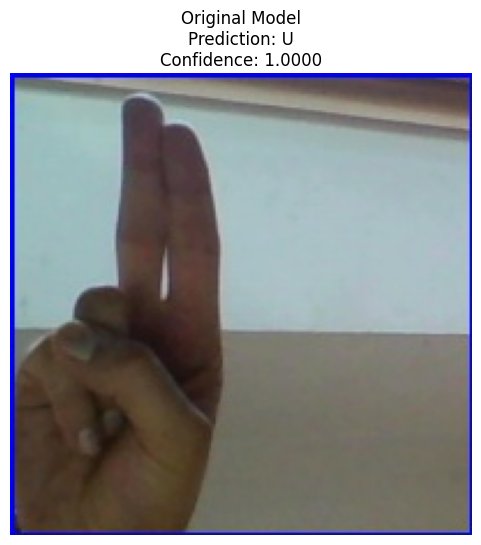


--- Running inference with INT8 quantized model ---


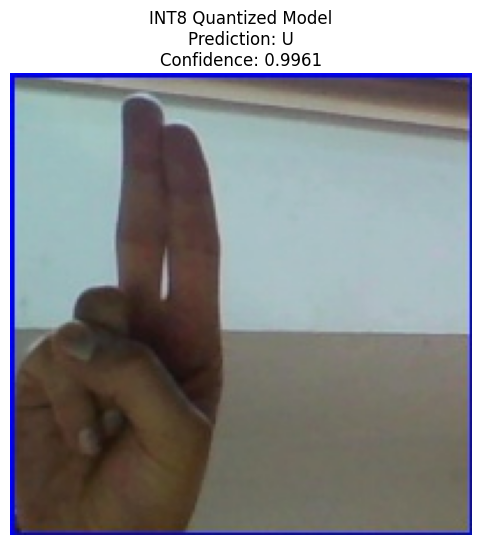


--- Running inference with Float16 quantized model ---


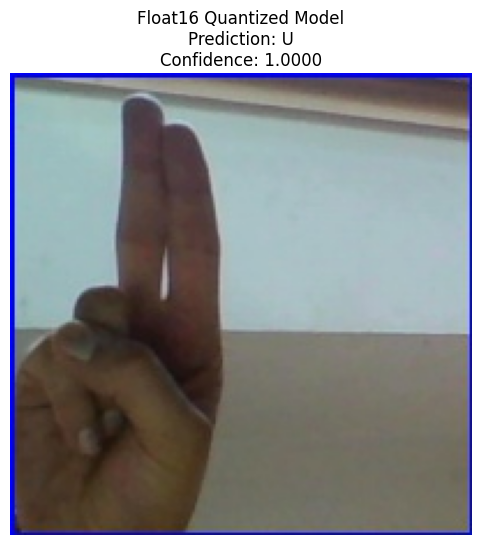

In [11]:
inference_demo()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Helper function to load and preprocess an image
def load_and_preprocess_image(image_path, img_height=200, img_width=200):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to run inference with the Keras model
def predict_with_model(model, image_path, class_indices):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    
    # Get class labels (invert the class_indices dictionary)
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Get the class label
    predicted_label = class_labels.get(predicted_class, f"Unknown class {predicted_class}")
    
    return predicted_label, confidence, img_array, predicted_class

# Function to run inference with TFLite model
def predict_with_tflite(tflite_model_path, image_path, class_indices):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Check if the model is quantized (uint8)
    is_quantized = input_details[0]['dtype'] == np.uint8
    
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    
    # Quantize the input if needed
    if is_quantized:
        input_scale, input_zero_point = input_details[0]['quantization']
        img_array = np.uint8(img_array / input_scale + input_zero_point)
    
    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize the output if needed
    if is_quantized:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
    
    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Get the prediction
    predicted_class = np.argmax(output_data[0])
    confidence = output_data[0][predicted_class]
    
    # Get the class label
    predicted_label = class_labels.get(predicted_class, f"Unknown class {predicted_class}")
    
    return predicted_label, confidence, img_array, predicted_class

# Function to visualize prediction results
def visualize_prediction(image_array, true_label, predicted_label, confidence, is_correct, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(image_array))
    
    # Color code based on prediction correctness
    color = 'green' if is_correct else 'red'
    
    plt.title(f"{title}\nTrue: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.4f}", 
              color=color)
    plt.axis('off')
    return plt.gcf()

# Comprehensive test on all ASL alphabet images
def test_all_classes(model_path, model_type, class_indices):
    # Prepare results containers
    results = {
        'correct': 0,
        'total': 0,
        'class_results': {}
    }
    
    # Get inverse mapping for class labels
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Check if it's a TFLite model or Keras model
    is_tflite = model_path.endswith('.tflite')
    
    # Load the Keras model if needed
    keras_model = None
    if not is_tflite:
        keras_model = tf.keras.models.load_model(model_path)
    
    # Create a figure with subplots for visualization
    n_classes = len(class_indices)
    fig, axes = plt.subplots(5, 6, figsize=(18, 15))  # 5x6 grid for 29 classes (with one empty)
    axes = axes.flatten()
    
    # Process each test image
    for class_name, class_idx in class_indices.items():
        # Construct the path for this test image
        test_image_path = f"asl_alphabet_test/{class_name}_test.jpg"
        
        # Check if image exists
        if not os.path.exists(test_image_path):
            print(f"Warning: Test image not found at {test_image_path}")
            results['class_results'][class_name] = {'found': False}
            continue
        
        # Perform prediction
        if is_tflite:
            # Use TFLite model
            predicted_label, confidence, img_array, predicted_class = predict_with_tflite(
                model_path, test_image_path, class_indices
            )
        else:
            # Use Keras model
            predicted_label, confidence, img_array, predicted_class = predict_with_model(
                keras_model, test_image_path, class_indices
            )
        
        # Check if prediction is correct
        is_correct = (predicted_class == class_idx)
        if is_correct:
            results['correct'] += 1
        results['total'] += 1
        
        # Store result for this class
        results['class_results'][class_name] = {
            'found': True,
            'is_correct': is_correct,
            'predicted': predicted_label,
            'confidence': float(confidence)
        }
        
        # Plot this result in the appropriate subplot
        if class_idx < len(axes):
            plt.sca(axes[class_idx])
            plt.imshow(np.squeeze(img_array))
            color = 'green' if is_correct else 'red'
            plt.title(f"{class_name} → {predicted_label}\n{confidence:.2f}", color=color)
            plt.axis('off')
    
    # Hide any unused subplots
    for i in range(n_classes, len(axes)):
        axes[i].axis('off')
    
    # Add overall title
    fig.suptitle(f"{model_type} - Accuracy: {results['correct']}/{results['total']} ({results['correct']/results['total']*100:.1f}%)", 
                 fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    # Save the visualization
    fig.savefig(f"{model_type.replace(' ', '_')}_results.png")
    
    return results

def inference_demo():
    # Define the class indices for ASL alphabet
    class_indices = {
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 
        'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 
        'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 
        'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
    }
    
    # Check if test directory exists
    test_dir = "asl_alphabet_test"
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        print(f"Created directory: {test_dir}")
        print("Please place your test images in this directory.")
        return
    
    # Check if trained models exist
    model_path = 'asl_model_final.h5'
    int8_model_path = 'asl_model_quantized_int8.tflite'
    float16_model_path = 'asl_model_quantized_float16.tflite'
    
    results = {}
    
    # # Test the original model
    # if os.path.exists(model_path):
    #     print("\n--- Testing original Keras model on all classes ---")
    #     results['original'] = test_all_classes(model_path, "Original Model", class_indices)
    #     accuracy = results['original']['correct'] / results['original']['total'] * 100
    #     print(f"Original model accuracy: {accuracy:.2f}%")
    # else:
    #     print(f"Original model not found at {model_path}")
    
    # # Test the INT8 quantized model
    if os.path.exists(int8_model_path):
        print("\n--- Testing INT8 quantized model on all classes ---")
        results['int8'] = test_all_classes(int8_model_path, "INT8 Model", class_indices)
        accuracy = results['int8']['correct'] / results['int8']['total'] * 100
        print(f"INT8 quantized model accuracy: {accuracy:.2f}%")
    else:
        print(f"INT8 quantized model not found at {int8_model_path}")
    
    # Test the Float16 quantized model
    # if os.path.exists(float16_model_path):
    #     print("\n--- Testing Float16 quantized model on all classes ---")
    #     results['float16'] = test_all_classes(float16_model_path, "Float16 Model", class_indices)
    #     accuracy = results['float16']['correct'] / results['float16']['total'] * 100
    #     print(f"Float16 quantized model accuracy: {accuracy:.2f}%")
    # else:
    #     print(f"Float16 quantized model not found at {float16_model_path}")
    
    # Compare results if we have multiple models
    model_types = [k for k in results.keys() if results[k]['total'] > 0]
    if len(model_types) > 1:
        print("\n--- Model Comparison ---")
        print(f"{'Model Type':<15} {'Accuracy':<10} {'Size':<10}")
        print("-" * 35)
        
        if 'original' in results:
            size = os.path.getsize(model_path) / (1024 * 1024)
            accuracy = results['original']['correct'] / results['original']['total'] * 100
            print(f"{'Original':<15} {accuracy:.2f}%{'':<4} {size:.2f} MB")
        
        if 'int8' in results:
            size = os.path.getsize(int8_model_path) / (1024 * 1024)
            accuracy = results['int8']['correct'] / results['int8']['total'] * 100
            print(f"{'INT8':<15} {accuracy:.2f}%{'':<4} {size:.2f} MB")
        
        if 'float16' in results:
            size = os.path.getsize(float16_model_path) / (1024 * 1024)
            accuracy = results['float16']['correct'] / results['float16']['total'] * 100
            print(f"{'Float16':<15} {accuracy:.2f}%{'':<4} {size:.2f} MB")
    
    return results

# Call the demo function
if __name__ == "__main__":
    inference_demo()

/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dcc3637/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5


--- Testing INT8 quantized model on all classes ---


In [19]:
import tensorflow as tf

model_path = "asl_model_quantized_int8.tflite"
interp = tf.lite.Interpreter(model_path=model_path)
interp.allocate_tensors()

print(f"{'tensor name':30s}  {'shape':15s}  {'type':6s}  {'scale':8s}  {'zero_point':10s}")
print("-"*80)
for d in interp.get_tensor_details():
    name, shape, dtype = d["name"], tuple(d["shape"]), d["dtype"].__name__
    scales = d["quantization_parameters"]["scales"]
    zps    = d["quantization_parameters"]["zero_points"]
    # most int8 models have exactly one scale & zp per tensor:
    s = scales[0] if len(scales)>0 else None
    z = zps[0]    if len(zps)>0    else None
    print(f"{name:30s}  {str(shape):15s}  {dtype:6s}  {s!s:8s}  {z!s:10s}")


tensor name                     shape            type    scale     zero_point
--------------------------------------------------------------------------------
serving_default_keras_tensor_30:0  (1, 200, 200, 3)  uint8   0.003921569  0         
arith.constant                  (2,)             int32   None      None      
tfl.pseudo_qconst               (29,)            int32   9.6694326e-05  0         
tfl.pseudo_qconst1              (29, 512)        int8    2.1665024e-05  0         
tfl.pseudo_qconst2              (512,)           int32   0.0023603172  0         
tfl.pseudo_qconst3              (512, 73728)     int8    0.0034320464  0         
tfl.pseudo_qconst4              (512,)           int8    0.005283292  113       
tfl.pseudo_qconst5              (512,)           int8    0.14908226  -128      
tfl.pseudo_qconst6              (512,)           int32   0.00040724964  0         
tfl.pseudo_qconst7              (512, 3, 3, 512)  int8    0.0026857082  0         
tfl.pseudo_qconst8   

In [24]:
from tensorflow.lite.python.interpreter import Interpreter

model_path = "asl_model_quantized_int8.tflite"
interp = Interpreter(model_path=model_path)
interp.allocate_tensors()

# pull out all tensor details in one list
tensor_details = interp.get_tensor_details()

# _get_ops_details() returns one dict per operator
for idx, op in enumerate(interp._get_ops_details()):
    name = op["op_name"]
    inp_idxs  = op["inputs"]
    out_idxs  = op["outputs"]
    inp_names = [ tensor_details[i]["name"] for i in inp_idxs  ]
    out_names = [ tensor_details[i]["name"] for i in out_idxs ]
    print(f"{idx:2d}: {name:15s}  inputs→{inp_names}  outputs→{out_names}")

 0: QUANTIZE         inputs→['serving_default_keras_tensor_30:0']  outputs→['tfl.quantize']
 1: CONV_2D          inputs→['tfl.quantize', 'tfl.pseudo_qconst35', 'tfl.pseudo_qconst34']  outputs→['sequential_1_1/sequential_1/conv2d_1/Relu;sequential_1_1/sequential_1/conv2d_1/BiasAdd;sequential_1_1/sequential_1/conv2d_1/convolution;1']
 2: MUL              inputs→['sequential_1_1/sequential_1/conv2d_1/Relu;sequential_1_1/sequential_1/conv2d_1/BiasAdd;sequential_1_1/sequential_1/conv2d_1/convolution;1', 'tfl.pseudo_qconst33']  outputs→['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/mul_1']
 3: ADD              inputs→['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/mul_1', 'tfl.pseudo_qconst32']  outputs→['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/add_1']
 4: CONV_2D          inputs→['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/add_1', 'tfl.pseudo_qconst31', 'tfl.pseudo_qconst30']  outputs→['sequential_1_1/sequential_1/conv2d_1_2/

/home/donald/.local/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [28]:
import tensorflow as tf
from tensorflow.lite.python.interpreter import Interpreter

# 1) Load your INT8 TFLite model
model_path = "asl_model_quantized_int8.tflite"
interp = Interpreter(model_path=model_path)
interp.allocate_tensors()

# 2) Grab all tensor details up front
tensor_details = interp.get_tensor_details()

# 3) Use the interpreter’s private _get_ops_details() to enumerate ops
print(f"{'idx':>3s}  {'op name':20s}  {'inputs':40s}  {'outputs'}")
print("-"*90)

for idx, op in enumerate(interp._get_ops_details()):
    # op["op_name"] is e.g. "CONV_2D", "FULLY_CONNECTED", etc.
    name    = op["op_name"]
    inp_ids = op["inputs"]
    out_ids = op["outputs"]
    # map tensor indices → tensor names
    inp_names  = [ tensor_details[i]["name"] for i in inp_ids  ]
    out_names  = [ tensor_details[i]["name"] for i in out_ids ]
    print(f"{idx:3d}  {name:20s}  {str(inp_names):40s}  {out_names}")


idx  op name               inputs                                    outputs
------------------------------------------------------------------------------------------
  0  QUANTIZE              ['serving_default_keras_tensor_30:0']     ['tfl.quantize']
  1  CONV_2D               ['tfl.quantize', 'tfl.pseudo_qconst35', 'tfl.pseudo_qconst34']  ['sequential_1_1/sequential_1/conv2d_1/Relu;sequential_1_1/sequential_1/conv2d_1/BiasAdd;sequential_1_1/sequential_1/conv2d_1/convolution;1']
  2  MUL                   ['sequential_1_1/sequential_1/conv2d_1/Relu;sequential_1_1/sequential_1/conv2d_1/BiasAdd;sequential_1_1/sequential_1/conv2d_1/convolution;1', 'tfl.pseudo_qconst33']  ['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/mul_1']
  3  ADD                   ['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/mul_1', 'tfl.pseudo_qconst32']  ['sequential_1_1/sequential_1/batch_normalization_1/batchnorm/add_1']
  4  CONV_2D               ['sequential_1_1/sequential_1/ba

/home/donald/.local/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
